## Рекомендация тарифов

### Описание проекта

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на новые тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — сделана ранее в предыдущем проекте.

Необходимо построить модель с максимально большим значением *accuracy*, и довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке.

### Описание данных
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

	• сalls — количество звонков,
	• minutes — суммарная длительность звонков в минутах,
	• messages — количество sms-сообщений,
	• mb_used — израсходованный интернет-трафик в Мб,
    • is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откроем и изучим файл

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns # Хор библ., красочные визуализации, меньше кода

In [4]:
df = pd.read_csv('users_behavior.csv')
# df = pd.read_csv('/datasets/users_behavior.csv')

In [5]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
# смотрим размеры 
df.shape

(3214, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## Разобьём данные на выборки

In [8]:
features = df.drop(['is_ultra'], axis=1)

In [9]:
target = df['is_ultra']

In [10]:
# делим датафрейм на две равные части с учётом стратификации
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size = 0.5, random_state=12345, stratify = target)

In [11]:
# вторую часть делим ещё на две равные части с учётом стратификации
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size = 0.5, random_state=12345, stratify = target_valid)

In [12]:
# посмотрим размеры выборок
features_train.shape, target_train.shape, \
features_valid.shape, target_valid.shape, \
features_test.shape, target_test.shape

((1607, 4), (1607,), (803, 4), (803,), (804, 4), (804,))

## Исследуем модели

#### Модель дерево решений

In [13]:
# Модель дерево решений
model_decision_tree = DecisionTreeClassifier(
    random_state=12345, max_depth = 5)

In [14]:
# обучим модель
model_decision_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=5, random_state=12345)

In [15]:
# подготовим прогноз
pred_decision_tree_valid = \
model_decision_tree.predict(features_valid)

In [16]:
# посмотрим точность score
accuracy_score(target_valid, pred_decision_tree_valid)

0.7683686176836861

In [17]:
# посмотрим меру f1
f1_score(target_valid, pred_decision_tree_valid)

0.5507246376811594

In [18]:
# найдем лучшие параметры глубины дерева с помощью цикла
best_result = 0
max_depth_list = []
result_list = []
result_train_list = []
for depth in range(1, 35):

    # создадим модель с параметром задаваемым в цикле
    model_decision_tree = DecisionTreeClassifier(
    random_state=12345, max_depth = depth)
    # обучим модель
    model_decision_tree.fit(features_train, target_train)
    # подготовим прогноз
    pred_decision_tree_valid = model_decision_tree.predict(features_valid)
    # посчитаем точность
    result = accuracy_score(target_valid, pred_decision_tree_valid)
    f1 = f1_score(target_valid, pred_decision_tree_valid)
    # запишем параметры в список
    max_depth_list.append(depth)
    result_list.append(result)
    
    # Запишем трейн
    pred_decision_tree_train = model_decision_tree.predict(features_train)
    result_train = accuracy_score(target_train, pred_decision_tree_train)
    result_train_list.append(result_train)
    
    # найдем лучшую модель
    if result > best_result:
        best_result = result
        best_model_decision_tree = model_decision_tree
        best_f1 = f1
        
print('best_model_decision_tree', best_model_decision_tree)
print('best_result_accuracy_score', best_result)
print('best_f1', f1)
    
    

best_model_decision_tree DecisionTreeClassifier(max_depth=10, random_state=12345)
best_result_accuracy_score 0.7845579078455791
best_f1 0.571992110453649


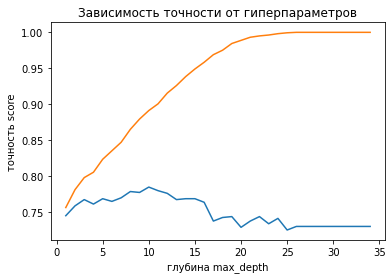

In [19]:
# построим график зависимости точности от параметров
# верхний график для прогноза на трейне
# нижний график для прогноза на валидационных данных
# plt.figure(figsize=(10, 5))
plt.plot(max_depth_list, result_list,label="x^2")
plt.plot(max_depth_list, result_train_list, label="x^123")

plt.xlabel('глубина max_depth')
plt.ylabel('точность score')
plt.title('Зависимость точности от гиперпараметров')
plt.show()

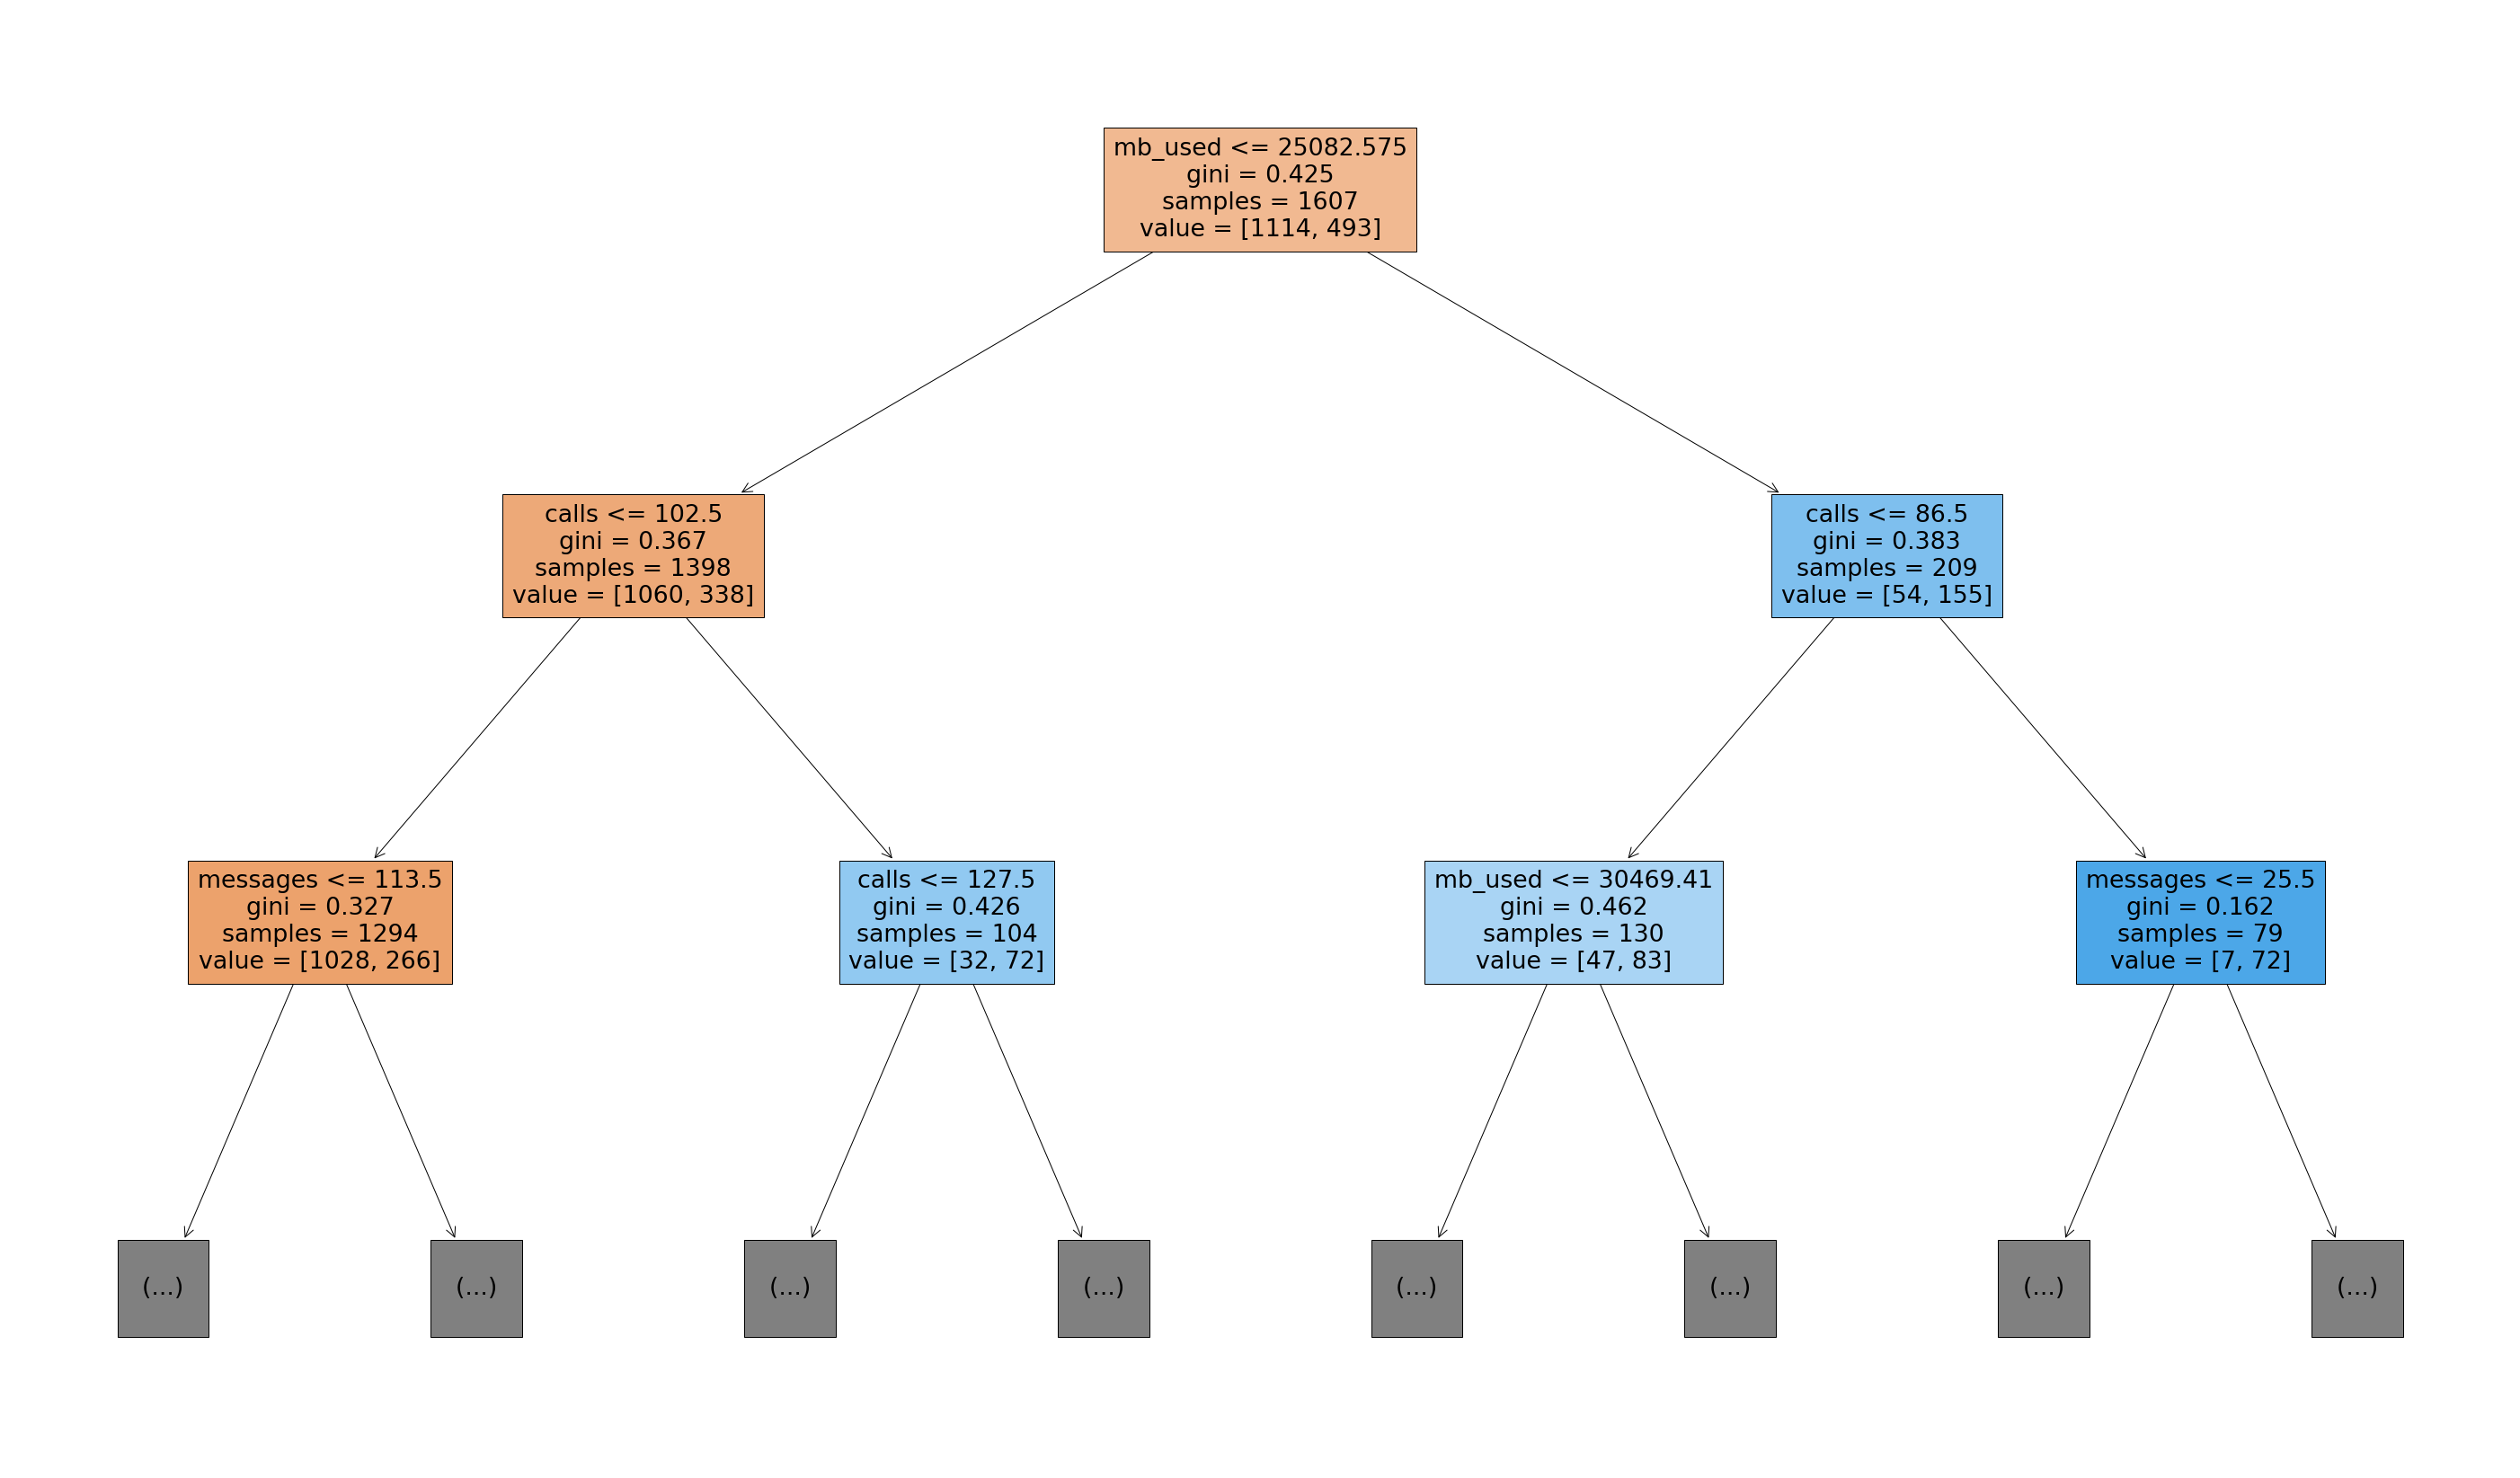

In [20]:
# построим первые ветки plot_tree
plt.figure(figsize=(50, 30))
plot_tree(best_model_decision_tree, feature_names=features_train.columns, filled = True, max_depth=2)
plt.title('')
plt.show()

#### Модель случайный лес

In [21]:
# Модель случайный лес 
model_random_forest = RandomForestClassifier(
    random_state=12345, max_depth = 5, n_estimators=10)

In [22]:
# обучим модель
model_random_forest.fit(features_train, target_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345)

In [23]:
# подготовим прогноз
pred_random_forest_valid = \
model_random_forest.predict(features_valid)
accuracy_score(target_valid, pred_random_forest_valid)

0.775840597758406

In [24]:
# посмотрим меру f1
f1_score(target_valid, pred_random_forest_valid)

0.5360824742268042

In [25]:
%%time
# Найдем лучшую модели и параметры с помощью цикла

best_result_random_forest = 0
forest_depth_list = []
forest_estimator_list = []
forest_score_list = []
for depth in range(1, 16):
    for estimator in range(10, 51, 10):
        # создадим модель с параметром задаваемым в цикле
        model_random_forest = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators = estimator)
        # обучим модель
        model_random_forest.fit(features_train, target_train)
        # подготовим прогноз
        pred_random_forest_valid = \
        model_random_forest.predict(features_valid)
        # посчитаем точность
        result = accuracy_score(target_valid, pred_random_forest_valid)
        f1 = f1_score(target_valid, pred_random_forest_valid)
        # запишем параметры в списки
        forest_depth_list.append(depth)
        forest_estimator_list.append(estimator)
        forest_score_list.append(result)
        
        # найдем лучшую модель       
        if result > best_result_random_forest:
#             print(result, "больше чем", best_result_random_forest)
            best_result_random_forest = result
            best_model_random_forest = model_random_forest
            best_estimator = estimator
            best_f1 = f1
        
print('best_model_random_forest', best_model_random_forest)
# print('best_estimator', best_estimator)
print('best_result_accuracy_score', best_result_random_forest)
print('best_f1', f1)

best_model_random_forest RandomForestClassifier(max_depth=9, n_estimators=20, random_state=12345)
best_result_accuracy_score 0.8069738480697385
best_f1 0.6273584905660378
Wall time: 9.45 s


<div class="alert alert-info"> <b>Комментарии студента:</b>Добавил визуализацию</div>

C:\Users\lazarevnv\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 720x360 with 0 Axes>

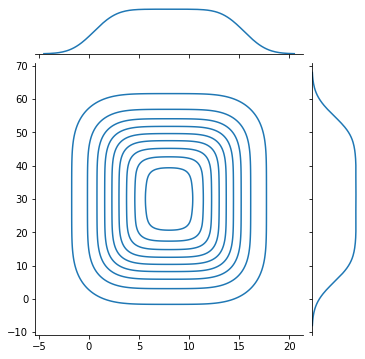

In [26]:
# визуализируем зависимость точности от двух гиперпараметров
plt.figure(figsize=(10, 5))

grid = sns.jointplot(forest_depth_list, forest_estimator_list, kind='kde') # здесь кде - красивая визуализация. Долго
grid.fig.set_figwidth(5) 
grid.fig.set_figheight(5)
plt.show()


#### Модель логистическая регрессия

In [27]:
# Модель логистическая регрессия
model_logistic_regression = LogisticRegression(
    random_state=12345, solver='lbfgs', max_iter=100)

In [28]:
model_logistic_regression.fit(features_train, target_train)

LogisticRegression(random_state=12345)

In [29]:
pred_logistic_regression_valid = \
model_logistic_regression.predict(features_valid)
accuracy_score(target_valid, pred_logistic_regression_valid)

0.7372353673723536

In [30]:
# посмотрим меру f1
f1_score(target_valid, pred_logistic_regression_valid)

0.32587859424920124

Лучшие параметры (best_result_accuracy_score 0.8069738480697385) на тренировочной выборке показала модель случайный лес с параметрами max_depth=9, n_estimators=20

## Проверьте модель на тестовой выборке

In [31]:
# получим прогноз на тестовой выборке
pred_random_forest_test = best_model_random_forest.predict(features_test)

In [32]:
# посмотрим точность прогноза лучшей модели случайного леса
accuracy_score(target_test, pred_random_forest_test)

0.8134328358208955

In [33]:
# посмотрим меру f1 лучшей модели случайного леса
f1_score(target_test, pred_random_forest_test)

0.6411483253588517

In [34]:
features_train.shape, target_train.shape

((1607, 4), (1607,))

In [35]:
features_valid.shape, target_valid.shape

((803, 4), (803,))

In [36]:
# обучим модель на объединенной выборке train+valid
# для этого объединим выборки
features_train_valid = pd.concat((features_train, features_valid), axis=0)
target_train_valid = pd.concat((target_train, target_valid), axis=0)
features_train_valid.shape, target_train_valid.shape

((2410, 4), (2410,))

In [37]:
# создадим модель с лучшими параметрами
model_random_forest = RandomForestClassifier(random_state=12345, max_depth = 9, n_estimators = 20)
# обучим модель
model_random_forest.fit(features_train_valid, target_train_valid)
# подготовим прогноз
pred_random_forest_test = \
model_random_forest.predict(features_test)
# посчитаем точность
result = accuracy_score(target_test, pred_random_forest_test)
f1 = f1_score(target_test, pred_random_forest_test)

In [38]:
print('accuracy_score', result)
print('f1', f1)

accuracy_score 0.8208955223880597
f1 0.6538461538461539


Наше предположение подтвердилось. На объединенной выборке train_valid получилось обучить модель, и подготовить более точный прогноз.

## Проверим модели на адекватность

In [39]:
from sklearn.dummy  import  DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

In [40]:
dummy_clf.fit(features_train_valid, target_train_valid)

DummyClassifier(strategy='most_frequent')

In [41]:
dummy_clf.predict(features_train_valid)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [42]:
dummy_clf.score(features_train_valid, target_train_valid)

0.6933609958506224

In [43]:
# задаем константную модель, которая будет предсказывать по most_frequent - самый частый класс
dummy_clf_correct = DummyClassifier(strategy='most_frequent', random_state=1)  

In [44]:
# тут модель смотрит на самый частый класс в target_train - типо "обучение"
dummy_clf_correct.fit(features_train, target_train)

DummyClassifier(random_state=1, strategy='most_frequent')

In [45]:
# проогнозирует везде самый частый класс в features_test 
dummy_clf_correct.predict(features_valid)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [46]:
# и считает score
dummy_clf_correct.score(features_test, target_test)

0.6940298507462687

## Общий вывод

По результатам данного проекта удалось построить прогнозную модель с точностью accuracy = 0.82

Целевой признак был присвоен переменной target
Данные были разбиты на три выборки train, valid, test. Разбивка проведена с учетом стратификации - случайного выбора объектов.

Всего в работе были применены и исследованы три варианта моделирования: решающее дерево, случайный лес и логистическая регрессия. Данные модели были выбраны как наиболее характерные для прогноза бинарной классификации при обучении с учителем.

Логистическая регрессия была рассчитана в единственном варианте и показала удовлетворительный результат точности accuracy = 0.73

Для моделей на дереве решений были проанализированы пятнадцать вариантов глубины дерева от 1 до 15. Наилучший результат на валидационной выборке показала модель с глубиной дерева = 10.

На валидационных данных модель дерева решений с указанными параметрами показала точность accuracy = 0.788, а также параметр f1 = 0.589

Для моделей случайного леса были проанализированы 75 вариантов. С глубиной деревьев от 1 до 15, и количеством девьев от 10 до 50 с шагом 10. Наилучший результат на валидационной выборке показала модель с 20-тью деревьями глубиной 9, accuracy = 0.80697,  а также параметр f1 = 0.590

**На тестовых данных модель случайного леса с указанными параметрами показала точность accuracy = 0.8134, а также параметр f1 = 0.641. 
Таже удалось улучшить показатели путем повторного обучения модели на данных совместной выборки train+valid. Точность accuracy = 0.8208
Это наилучший результат в данной работе.**

Далее лучшие модели были проверены на адекватность с помощью метода DummyClassifier score = 0.693

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
